In [1]:
#%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.stats import entropy, mannwhitneyu, pearsonr, wilcoxon
from sklearn import metrics

from scorer.scorer import Score

## Data preparation

In [2]:
cases = pd.read_csv("tests/data/paper_example/cases_long.csv")
cases.head()

,x1,x2,data_label,value
0,0.0,0.0,one,0
1,0.0,1.0,one,0
2,0.0,2.0,one,0
3,0.0,3.0,one,0
4,0.0,4.0,one,0


In [3]:
signals = pd.read_csv("tests/data/paper_example/imputed_signals_long.csv")
signals.head()

,x1,x2,signal_label,value
0,0.0,0.0,w_A,0.0
1,0.0,1.0,w_A,0.0
2,0.0,2.0,w_A,0.0
3,0.0,3.0,w_A,0.0
4,0.0,4.0,w_A,0.0


In [4]:
def plot_grid(series, title):
    ax = sns.heatmap(
        series.values.reshape(5, -1).T,
        linewidth=2,
        cmap="RdPu",
        cbar=False,
        annot=True,
    )

    ax.add_patch(
        Rectangle(
            (0, 4),
            1,
            1,
            fill=False,
            lw=3,
            color="green",
        )
    )
    ax.add_patch(
        Rectangle(
            (1, 1),
            2,
            2,
            fill=False,
            lw=3,
            color="blue",
        )
    )
    ax.add_patch(
        Rectangle(
            (3, 0),
            2,
            1,
            fill=False,
            lw=3,
            color="blue",
            alpha=0.5,
        )
    )
    ax.add_patch(
        Rectangle(
            (2, 2),
            3,
            3,
            fill=False,
            lw=3,
            color="orange",
            alpha=0.5,
        )
    )
    ax.set_title(title)
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 5)
    return ax

In [5]:
s = Score(cases,signals)

not imputeded


### Calculate signal for endemic and non-case when not given by algo

In [6]:
pd.read_csv("tests/data/paper_example/signals_long.csv").head()

,x1,x2,signal_label,value
0,0.0,0.0,w_A,0.0
1,0.0,1.0,w_A,0.0
2,0.0,2.0,w_A,0.0
3,0.0,3.0,w_A,0.0
4,0.0,4.0,w_A,0.0


In [7]:
Score.impute_signals(cases, pd.read_csv("tests/data/paper_example/signals_long.csv"))

,x1,x2,signal_label,value
0,0.0,0.0,w_A,0.0
1,0.0,1.0,w_A,0.0
2,0.0,2.0,w_A,0.0
3,0.0,3.0,w_A,0.0
4,0.0,4.0,w_A,0.0
...,...,...,...,...
70,4.0,0.0,w_C,0.0
71,4.0,1.0,w_C,0.0
72,4.0,2.0,w_C,0.0
73,4.0,3.0,w_C,0.0


<AxesSubplot:title={'center':'endemic signal'}>

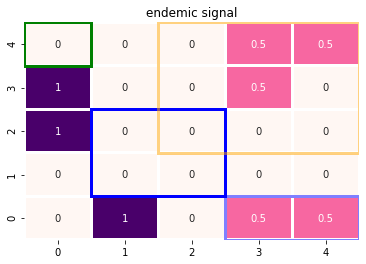

In [8]:
imputed_signal = Score.impute_signals(pd.read_csv("tests/data/paper_example/non_case_imputed_long.csv"), pd.read_csv("tests/data/paper_example/signals_long.csv"))
endemic_imputed = imputed_signal.query("signal_label=='w_endemic'").value
plot_grid(
    endemic_imputed,
    "endemic signal",
)

<AxesSubplot:title={'center':'non_case signal'}>

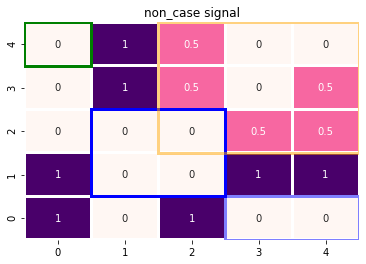

In [10]:
imputed_signal = Score.impute_signals(pd.read_csv("tests/data/paper_example/non_case_imputed_long.csv"), pd.read_csv("tests/data/paper_example/signals_long.csv"))
endemic_imputed = imputed_signal.query("signal_label=='w_non_case'").value
plot_grid(
    endemic_imputed,
    "non_case signal",
)

## Score calculation (regression)

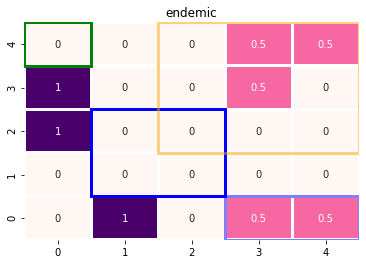

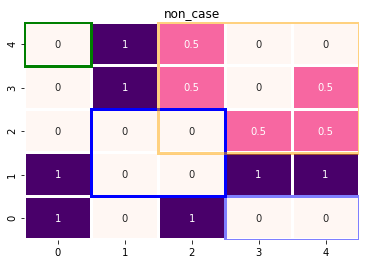

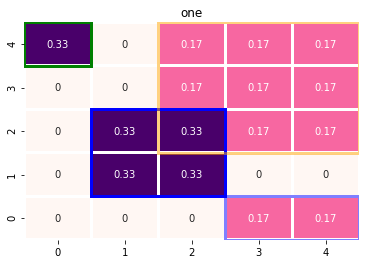

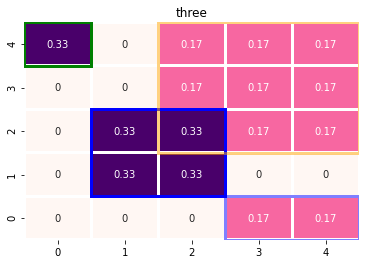

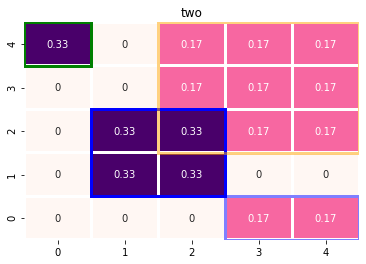

In [11]:
for datalabel in s.p_hat_di().d_i.unique():
    plot_grid(s.p_hat_di().query("d_i==@datalabel").loc[:, ["p^(d_i)"]], datalabel)
    plt.show()

In [12]:
time = s.timeliness("x2", 4)
time

{'three': 1.0, 'one': 1.0, 'two': 0.5}

In [13]:
s.mean_score(metrics.f1_score)

(0.5175213675213676, 0.7006081525312294)

In [14]:
def KL(P, Q):
    """Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0."""
    epsilon = 0.00001

    P = P + epsilon
    Q = Q + epsilon

    divergence = np.sum(P * np.log(P / Q))
    return divergence


print("KL")
print(KL(s.eval_df()["p(d_i)"].values / 25, s.eval_df()["p^(d_i)"].values / 25))
print("KL form scikitlearn")
print(entropy(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values + 0.00001))
print("mutual information")
print(
    metrics.mutual_info_score(
        s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values
    )
)
print("regression score")
print(metrics.r2_score(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values))
print("RMSE")
print(
    np.sqrt(
        np.mean((s.eval_df()["p(d_i)"].values - s.eval_df()["p^(d_i)"].values) ** 2)
    )
)
print("MSE")
print(np.mean((s.eval_df()["p(d_i)"].values - s.eval_df()["p^(d_i)"].values) ** 2))
print("Correlation")
print(pearsonr(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values))
print("Signed-Wilcoxon")
print(
    wilcoxon(
        s.eval_df()["p(d_i)"].values,
        s.eval_df()["p^(d_i)"].values,
        alternative="two-sided",
    )
)
print("U-test")
print(
    mannwhitneyu(
        s.eval_df()["p(d_i)"].values,
        s.eval_df()["p^(d_i)"].values,
        alternative="two-sided",
    )
)

KL
1.4657710594873727
KL form scikitlearn
1.8546735918556878
mutual information
0.29634980972036773
regression score


C:\Users\AbboodA\Miniconda3\envs\scoring\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


0.3965014577259477
RMSE
0.30331501776206204
MSE
0.092
Correlation
(0.6358779630814554, 1.6222647280089715e-15)
Signed-Wilcoxon
WilcoxonResult(statistic=887.5, pvalue=0.8375532487088458)
U-test
MannwhitneyuResult(statistic=6132.5, pvalue=0.0006548121605249147)


### Confusion Matrix

In [15]:
s.class_based_conf_mat()

{'endemic': [[16, 4], [1, 4]],
 'non_case': [[13, 0], [0, 12]],
 'one': [[20, 2], [0, 3]],
 'three': [[18, 5], [2, 0]],
 'two': [[17, 4], [3, 1]]}

In [16]:
s.class_based_conf_mat(weighted=True)

{'endemic': [[20, 4], [1, 4]],
 'non_case': [[13, 0], [0, 12]],
 'one': [[20, 2], [0, 3]],
 'three': [[19, 5], [2, 0]],
 'two': [[17, 4], [3, 1]]}

In [17]:
s.eval_df()

,x1,x2,d_i,p(d_i),p^(d_i)
0,0.0,0.0,one,0.0,0.000000
1,0.0,1.0,one,0.0,0.000000
2,0.0,2.0,one,0.0,0.000000
3,0.0,3.0,one,0.0,0.000000
4,0.0,4.0,one,0.0,0.333333
...,...,...,...,...,...
120,4.0,0.0,non_case,0.0,0.000000
121,4.0,1.0,non_case,1.0,1.000000
122,4.0,2.0,non_case,1.0,0.500000
123,4.0,3.0,non_case,1.0,0.500000


### How to score when algo is a classifier
- We look into data distribution and set a cut-off based on data distribution. We assume that the non-outbreak numbers are highest around 0. This peak will flatten when we move away from 0. There we set a cut-off when the next peak is about to start (probably a outbreak cluster)
- Discretize p(d_i) into bins and predict vector of bins
- p(d_i) \element of {0,1} -> confusion matrix

R = [0,1]

B = {0,1}
- p \element R AND p^ \element R -> like the lower, when threshold for p^ is set to e.g., 0.5
- p \element R AND p^ \element B ->
- p \element B AND p^ \element R -> easy/known/ROC/AUC
- p \element B AND p^ \element B -> easy

### References
- KL, Entropy, MI (Wie macht es inhatlich Sinn die Entropie zu berechnen, gegeben den verschiedenen Zellen und DataLabels)
    - Referenz: https://arxiv.org/pdf/1802.03446.pdf
    - Referenz: https://www.sciencedirect.com/science/article/pii/S107731420700077X (pixel-based classifications)
    - Referenz: https://iopscience.iop.org/article/10.1088/1755-1315/47/1/012042/pdf (pixel-based classifications)
    - Likelihood methoden anschauen
    - https://en.wikipedia.org/wiki/Kernel_embedding_of_distributions

## TODO:    
- Geographisches weighting (distanz aller Zell-Kombis spielt eine Rolle)
- statt delays zu addieren, mittelwert der timeliness rechnen
- eventuell kombinieren

## Backlog:
- z-score-based binning (https://core.ac.uk/download/pdf/82692314.pdf)
    - in general quantiles
- attribute cell to data with highest probability
- evt Nouffeily Sim nutzen
- check if score is proper 
- entropy, KL, mutual information probieren abzuleiten und für unseren Fall anzuwenden

## Example scenarios

In [18]:
signal_bad = pd.DataFrame(product(range(5), range(5)), columns=["x1", "x2"]).assign(
    w_A=0., w_B=0., w_C=0.
).melt(id_vars=["x1", "x2"], var_name="signal_label")

score_bad = Score(cases, signal_bad)

print("R2: ")
print(
    metrics.r2_score(
        score_bad.eval_df()["p(d_i)"].values, score_bad.eval_df()["p^(d_i)"].values
    )
)

R2: 
0.24489795918367363


In [19]:
score_bad.class_based_conf_mat()

{'endemic': [[12, 8], [0, 5]],
 'non_case': [[13, 0], [0, 12]],
 'one': [[22, 0], [3, 0]],
 'three': [[23, 0], [2, 0]],
 'two': [[21, 0], [4, 0]]}

In [20]:
score_bad.mean_score(metrics.f1_score)

(0.3111111111111111, 0.5683760683760684)

In [21]:
signal_sensitive = pd.DataFrame(
    product(range(5), range(5)), columns=["x1", "x2"]
).assign(w_A=1., w_B=1., w_C=1.).melt(id_vars=["x1", "x2"], var_name="signal_label")

score_sensitive = Score(cases, signal_sensitive)

print("R2: ")
print(
    metrics.r2_score(
        score_sensitive.eval_df()["p(d_i)"].values,
        score_sensitive.eval_df()["p^(d_i)"].values,
    )
)

R2: 
-0.4314868804664722


In [22]:
score_sensitive.class_based_conf_mat()

{'endemic': [[20, 0], [5, 0]],
 'non_case': [[13, 0], [12, 0]],
 'one': [[0, 22], [0, 3]],
 'three': [[0, 23], [0, 2]],
 'two': [[0, 21], [0, 4]]}

In [23]:
score_sensitive.mean_score(metrics.f1_score)

(0.12765918627987594, 0.07856160442367341)

In [24]:
# Nicht blind one, two, three einfügen, sondern nur, wenn die Label >0
to_drop = ["one", "two", "three", "endemic", "non_case"]
signal_ideal_df = cases.pivot(index=["x1", "x2"], columns="data_label", values="value").assign(
    w_A=lambda x: np.where(x.endemic == 0, x.one, x.one / (x.one + x.endemic)),
    w_B=lambda x: np.where(x.endemic == 0, x.two, x.two / (x.two + x.endemic)),
    w_C=lambda x: np.where(x.endemic == 0, x.three, x.three / (x.three + x.endemic)),
).reset_index().melt(id_vars=["x1", "x2"], var_name="signal_label").query("not signal_label.isin(@to_drop)")

signal_ideal = Score(cases, signal_ideal_df)

print("R2: ")
print(
    metrics.r2_score(
        signal_ideal.eval_df()["p(d_i)"].values,
        signal_ideal.eval_df()["p^(d_i)"].values,
    )
)

R2: 
0.7657920310981536


In [25]:
signal_ideal.class_based_conf_mat()

{'endemic': [[19, 1], [0, 5]],
 'non_case': [[13, 0], [0, 12]],
 'one': [[17, 5], [0, 3]],
 'three': [[17, 6], [0, 2]],
 'two': [[17, 4], [0, 4]]}

In [26]:
signal_ideal.mean_score(metrics.f1_score)

(0.7042424242424242, 0.8326340326340328)

In [27]:
df_cases_1 = cases.query("data_label.isin(['one', 'endemic', 'non_case'])")

In [28]:
signal_specific_1 = cases.pivot(index=["x1", "x2"], columns="data_label", values="value").assign(
    w_A=lambda x: np.where(x.endemic == 0, x.one, x.one / (x.one + x.endemic)),
).reset_index().melt(id_vars=["x1", "x2"], var_name="signal_label").query("not signal_label.isin(@to_drop)")

score_specific_1 = Score(df_cases_1,signal_specific_1,)

print("R2: ")
print(
    metrics.r2_score(
        score_specific_1.eval_df()["p(d_i)"].values,
        score_specific_1.eval_df()["p^(d_i)"].values,
    )
)

R2: 
1.0


In [29]:
score_specific_1.class_based_conf_mat()

{'endemic': [[19, 0], [0, 6]],
 'non_case': [[9, 0], [0, 16]],
 'one': [[22, 0], [0, 3]]}

In [30]:
score_specific_1.mean_score(metrics.f1_score)

(1.0, 1.0)

In [31]:
from scipy.stats import entropy

In [32]:
print("entropy: ")
print(
    entropy(
        score_specific_1.eval_df()["p(d_i)"].values,
        score_specific_1.eval_df()["p^(d_i)"].values,
    )
)

entropy: 
0.0


In [33]:
0.6365141682948126 / np.log(2)

0.9182958340544891